# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups),  and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e. it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

import dataset_loader
from oxonfair import FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data['data'].shape,val_data['data'].shape,test_data['data'].shape

((24421, 14), (12210, 14), (12211, 14))

In [3]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [4]:
# Evaluate on test data
fpredictor.predict(test_data)

array([0, 0, 1, ..., 0, 0, 0])

In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.870527,0.853984
Balanced Accuracy,0.801481,0.771373
F1 score,0.712074,0.667661
MCC,0.631174,0.578837
Precision,0.760996,0.733115
Recall,0.669062,0.612936
ROC AUC,0.925576,0.826407


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.188330,0.021014
Predictive Parity,0.024491,0.343701
Equal Opportunity,0.113892,0.272117
Average Group Difference in False Negative Rate,0.113892,0.272117
Equalized Odds,0.090796,0.164818
Conditional Use Accuracy,0.052279,0.243413
Average Group Difference in Accuracy,0.090947,0.052501
Treatment Equality,0.203908,5.251126


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.870527           0.801481  0.712074  0.631174   
         0                   0.931324           0.773859  0.645408  0.614207   
         1                   0.840377           0.796955  0.723178  0.613236   
         Maximum difference  0.090947           0.023096  0.077770  0.000970   
updated  Overall             0.853984           0.771373  0.667661  0.578837   
         0                   0.889081           0.869256  0.624268  0.591911   
         1                   0.836580           0.761956  0.680096  0.594671   
         Maximum difference  0.052501           0.107300  0.055828  0.002761   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.760996  0.669062  0.925576   
         0                    0.739766  0.572398  0.940112   
         1                    0.764257  0.686290  0.908275   
         Maximum difference   0.024491  0.113892  0.031837   
updated  Overall              0.733115  0.612936  0.826407   
         0                    0.495352  0.843891  0.940112   
         1                    0.839053  0.571774  0.908275   
         Maximum difference   0.343701  0.272117  0.031837   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          12211.0          2922.0   
         0                                 4048.0           442.0   
         1                                 8163.0          2480.0   
         Maximum difference                4115.0          2038.0   
updated  Overall                          12211.0          2922.0   
         0                                 4048.0           442.0   
         1                                 8163.0          2480.0   
         Maximum difference                4115.0          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.210384  
         0                                   0.084486  
         1                                   0.272816  
         Maximum difference                  0.188330  
updated  Overall                             0.200066  
         0                                   0.186018  
         1                                   0.207032  
         Maximum difference                  0.021014

In [8]:
train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])


In [9]:
fpredictor = FairPredictor(predictor,val_data,'race') 
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [10]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Statistical Parity,0.109018,0.076311
Predictive Parity,0.033117,0.186202
Equal Opportunity,0.159850,0.219112
Average Group Difference in False Negative Rate,0.159850,0.219112
Equalized Odds,0.100719,0.131864
Conditional Use Accuracy,0.036888,0.130660
Average Group Difference in Accuracy,0.053225,0.037582
Treatment Equality,0.259746,6.710528


In [11]:
fpredictor.evaluate_fairness()

,original,updated
Statistical Parity,0.101929,0.019384
Predictive Parity,0.128801,0.151661
Equal Opportunity,0.160757,0.180761
Average Group Difference in False Negative Rate,0.160757,0.180761
Equalized Odds,0.104002,0.104552
Conditional Use Accuracy,0.092449,0.115558
Average Group Difference in Accuracy,0.064770,0.046175
Treatment Equality,0.302790,3.496003


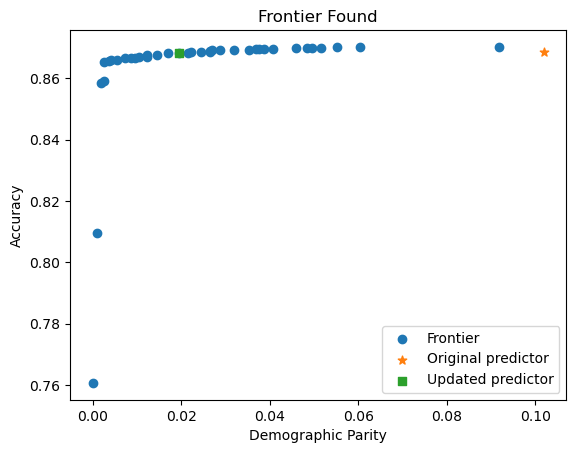

In [12]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

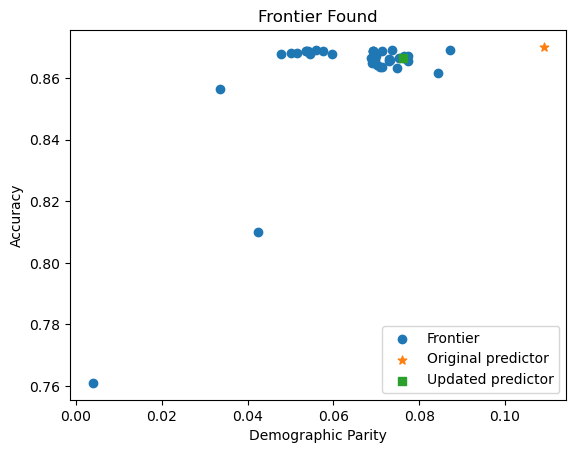

In [13]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [14]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.870035           0.797288  0.707789  0.627843   
         0                   0.936364           0.661716  0.461538  0.473568   
         1                   0.834734           0.773608  0.681081  0.572865   
         2                   0.926421           0.780790  0.669173  0.636968   
         3                   0.915966           0.740291  0.615385  0.590926   
         4                   0.863554           0.797954  0.712002  0.625900   
         Maximum difference  0.101630           0.136238  0.250463  0.163400   
updated  Overall             0.866432           0.786827  0.694398  0.614456   
         0                   0.909091           0.748075  0.500000  0.453295   
         1                   0.834734           0.761158  0.666667  0.565863   
         2                   0.902174           0.859649  0.675900  0.630884   
         3                   0.865546           0.922330  0.666667  0.649869   
         4                   0.862978           0.784099  0.697950  0.618199   
         Maximum difference  0.074357           0.174255  0.197950  0.196575   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.766042  0.657769  0.922670   
         0                    0.750000  0.333333  0.885589   
         1                    0.732558  0.636364  0.898089   
         2                    0.780702  0.585526  0.949618   
         3                    0.800000  0.500000  0.961165   
         4                    0.766449  0.664777  0.919172   
         Maximum difference   0.067442  0.331444  0.075576   
updated  Overall              0.767288  0.634155  0.896317   
         0                    0.454545  0.555556  0.885589   
         1                    0.756410  0.595960  0.898089   
         2                    0.583732  0.802632  0.949618   
         3                    0.500000  1.000000  0.961165   
         4                    0.791847  0.623961  0.919172   
         Maximum difference   0.337301  0.444444  0.075576   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          12211.0          2922.0   
         0                                  110.0             9.0   
         1                                  357.0            99.0   
         2                                 1196.0           152.0   
         3                                  119.0            16.0   
         4                                10429.0          2646.0   
         Maximum difference               10319.0          2637.0   
updated  Overall                          12211.0          2922.0   
         0                                  110.0             9.0   
         1                                  357.0            99.0   
         2                                 1196.0           152.0   
         3                                  119.0            16.0   
         4                                10429.0          2646.0   
         Maximum difference               10319.0          2637.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                            101.0             0.081818   
         1                            258.0             0.277311   
         2                           1044.0             0.127090   
         3                            103.0             0.134454   
         4                           7783.0             0.253716   
         Maximum difference          7682.0             0.195493   
updated  Overall                     9

In [15]:
#The groups with the smallest Positive Prediction Rate (corresponding to American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on validation data we find that there are less than 90 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.868550           0.794791  0.704038  0.623305   
         0                   0.888000           0.666667  0.500000  0.542020   
         1                   0.818428           0.755598  0.663317  0.546588   
         2                   0.925613           0.754264  0.633333  0.608911   
         3                   0.948980           0.827519  0.761905  0.743516   
         4                   0.862865           0.797320  0.710030  0.623230   
         Maximum difference  0.130551           0.160853  0.261905  0.201497   
updated  Overall             0.868223           0.787069  0.696358  0.618672   
         0                   0.848000           0.756639  0.577778  0.487206   
         1                   0.829268           0.750246  0.659459  0.568903   
         2                   0.914624           0.864657  0.694864  0.653662   
         3                   0.908163           0.911822  0.709677  0.682950   
         4                   0.864207           0.784772  0.698959  0.620283   
         Maximum difference  0.085356           0.161576  0.131900  0.195743   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.763295  0.653320  0.924039   
         0                    1.000000  0.333333  0.897436   
         1                    0.741573  0.600000  0.902984   
         2                    0.791667  0.527778  0.952000   
         3                    0.888889  0.666667  0.978682   
         4                    0.761739  0.664896  0.920673   
         Maximum difference   0.258427  0.333333  0.081246   
updated  Overall              0.776188  0.631417  0.898137   
         0                    0.541667  0.619048  0.897436   
         1                    0.813333  0.554545  0.902984   
         2                    0.614973  0.798611  0.952000   
         3                    0.578947  0.916667  0.978682   
         4                    0.793919  0.624288  0.920673   
         Maximum difference   0.271667  0.362121  0.081246   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          12210.0          2922.0   
         0                                  125.0            21.0   
         1                                  369.0           110.0   
         2                                 1183.0           144.0   
         3                                   98.0            12.0   
         4                                10435.0          2635.0   
         Maximum difference               10337.0          2623.0   
updated  Overall                          12210.0          2922.0   
         0                                  125.0            21.0   
         1                                  369.0           110.0   
         2                                 1183.0           144.0   
         3                                   98.0            12.0   
         4                                10435.0          2635.0   
         Maximum difference               10337.0          2623.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                            104.0             0.168000   
         1                            259.0             0.298103   
         2                           1039.0             0.121724   
         3                             86.0             0.122449   
         4                           7800.0             0.252516   
         Maximum difference          7714.0             0.176379   
updated  Overall                     9

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [16]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [17]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [18]:
fpredictor=FairPredictor(predictor2, train, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [19]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [20]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [21]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, train_g, 'race')
#and then evaluate it
true_groups = evaluate(fpredictor, gm.clarify_metrics, test_g)

true_groups

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.159466,0.011079,0.657563,0.646218
Disparate Impact,0.623388,0.944255,0.657563,0.647899
Average Group Difference in Conditional Acceptance Rate,0.351803,0.064117,0.657563,0.650000
Average Group Difference in Conditional Rejectance Rate,0.052968,0.044369,0.657563,0.653361
Average Group Difference in Accuracy,0.017547,0.011044,0.657563,0.653361
Average Group Difference in Recall,0.166757,0.063227,0.657563,0.648319
Average Group Difference in Acceptance Rate,0.062387,0.093970,0.657563,0.651681
Average Group Difference in Specificity,0.107465,0.026887,0.657563,0.649580
Average Group Difference in Rejection Rate,0.050992,0.040492,0.657563,0.652941
Treatment Equality,0.223708,0.074627,0.657563,0.647059


In [22]:
 # Now using infered attributes
#Note that group information is not present in train['data']
#But contained in train['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, train, inferred_groups=protected) 
inferred = evaluate(fpredictor2, gm.clarify_metrics, test)
inferred

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.151470,0.084651,0.67395,0.627731
Disparate Impact,0.677047,0.736657,0.67395,0.619328
Average Group Difference in Conditional Acceptance Rate,0.225513,0.176817,0.67395,0.657563
Average Group Difference in Conditional Rejectance Rate,0.067061,0.048793,0.67395,0.665546
Average Group Difference in Accuracy,0.019008,0.021466,0.67395,0.670588
Average Group Difference in Recall,0.145031,0.082055,0.67395,0.630672
Average Group Difference in Acceptance Rate,0.057459,0.060132,0.67395,0.680252
Average Group Difference in Specificity,0.103984,0.090335,0.67395,0.665126
Average Group Difference in Rejection Rate,0.051372,0.052749,0.67395,0.671849
Treatment Equality,0.249687,0.168621,0.67395,0.666387


In [24]:
fpredictor2.evaluate_groups(test)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.673950           0.664093  0.609265  0.335820   
         African-American    0.660377           0.660899  0.660656  0.321783   
         Caucasian           0.688889           0.649490  0.540146  0.324394   
         Other               0.686610           0.630009  0.495413  0.285117   
         Maximum difference  0.028512           0.030889  0.165243  0.039278   
updated  Overall             0.666387           0.651951  0.577210  0.319619   
         African-American    0.648893           0.651007  0.628472  0.304834   
         Caucasian           0.688889           0.641803  0.515385  0.320808   
         Other               0.675214           0.607442  0.446602  0.247247   
         Maximum difference  0.039996           0.043566  0.181870  0.073562   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.662651  0.563840  0.714265   
         African-American     0.679595  0.642743  0.706468   
         Caucasian            0.646288  0.463950  0.693601   
         Other                0.593407  0.425197  0.715323   
         Maximum difference   0.086189  0.217546  0.021722   
updated  Overall              0.673292  0.505126  0.703703   
         African-American     0.689524  0.577352  0.693327   
         Caucasian            0.666667  0.420063  0.687318   
         Other                0.582278  0.362205  0.708960   
         Maximum difference   0.107245  0.215148  0.021642   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                           2380.0          1073.0   
         African-American                  1219.0           627.0   
         Caucasian                          810.0           319.0   
         Other                              351.0           127.0   
         Maximum difference                 868.0           500.0   
updated  Overall                           2380.0          1073.0   
         African-American                  1219.0           627.0   
         Caucasian                          810.0           319.0   
         Other                              351.0           127.0   
         Maximum difference                 868.0           500.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   
updated  Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.383613  
         African-American                    0.486464  
         Caucasian                           0.282716  
         Other                               0.259259  
         Maximum difference                  0.227205  
updated  Overall                             0.338235  
         African-American                    0.430681  
         Caucasian                           0.248148  
         Other                               0.225071  
         Maximum difference                  0.205610

In [25]:
from oxonfair import conditional_group_metrics as cgm
fpredictor2_cond = FairPredictor(predictor2, train, inferred_groups=protected,conditioning_factor='sex') 
fpredictor2_cond.fit(gm.accuracy,cgm.pos_pred_rate.diff,0.02)

In [27]:
fpredictor2_cond.evaluate(metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.728265,0.669467
Average Group Difference in Conditional Positive Prediction Rate,0.141604,0.019039


In [28]:
fpredictor2_cond.evaluate(test,metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.673950,0.626471
Average Group Difference in Conditional Positive Prediction Rate,0.150927,0.073203
